In [2]:
import sys
sys.path.append('..')

import cvxopt
import numpy as np
import matplotlib.pyplot as plt

import metrics

The objective is:
    
$$\min_{x} \frac{1}{2} x^T P x + q^Tx$$
$$\text{s.t. } Gx \leq h$$
$$\text{s.t. } Ax = b$$

with:
- $x \in \mathbb{R}^n$, the unknown we are looking for
- $P \in \mathbb{R}^{n*n}$
- $q \in \mathbb{R}^n$
- $G \in \mathbb{R}^{m * n}$
- $h \in \mathbb{R}^m$
- $A \in \mathbb{R}^{p * n}$
- $b \in \mathbb{R}^p$

In [56]:
def plot_data(b, b0, X, y):

    #bo + b1x1 + b2x2 = 0 => x2 = -b1/b2*x1 - b0/b2 
    x1 = np.linspace(np.min(X[:,0]) - 10, np.max(X[:,0]) + 10, 1000)
    plt.plot(x1, -b[0]/b[1]*x1 -b0/b[1])
    
    b10 = b / np.linalg.norm(b) * 10
    plt.plot([0, b10[0]], [-b0/b[1], b10[1]-b0/b[1]], c='y')
    
    for i in range(len(X)):
        plt.scatter(X[i][0], X[i][1], c=('r' if y[i] == 1 else 'g'))

    plt.axis('equal')
    plt.grid()
    plt.show()

def plot_data_support(b, b0, X, y):

    #bo + b1x1 + b2x2 = 0 => x2 = -b1/b2*x1 - b0/b2 
    x1 = np.linspace(np.min(X[:,0]) - 10, np.max(X[:,0]) + 10, 1000)
    plt.plot(x1, -b[0]/b[1]*x1 -b0/b[1])
    plt.plot(x1, (1 - b0 - b[0] * x1)/b[1], c='orange')
    plt.plot(x1, (-1 - b0 - b[0] * x1)/b[1], c='orange')
            
    b10 = b / np.linalg.norm(b) * 10
    plt.plot([0, b10[0]], [-b0/b[1], b10[1]-b0/b[1]], c='y')
    
    for i in range(len(X)):
        plt.scatter(X[i][0], X[i][1], c=('r' if y[i] == 1 else 'g'))

    plt.axis('equal')
    plt.grid()
    plt.show()

def svm_hard_lib(X, y):
    n, p = X.shape
    X = X.astype(np.double)
    y = y.astype(np.double)
    
    H = (y.reshape(-1, 1)*X @ (y.reshape(-1, 1)*X).T)
    
    P = cvxopt.matrix(H)
    q = cvxopt.matrix(-np.ones((n, 1)))
    G = cvxopt.matrix(-np.eye(n))
    h = cvxopt.matrix(np.zeros((n,)))
    A = cvxopt.matrix(y.reshape(1, -1))
    b = cvxopt.matrix(np.zeros((1,)))
    
    cvxopt.solvers.options['show_progress'] = False
    cvxopt.solvers.options['abstol'] = 1e-10
    cvxopt.solvers.options['reltol'] = 1e-10
    cvxopt.solvers.options['feastol'] = 1e-10
    
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    alpha = np.array(sol['x']).flatten()
    
    beta = (y * alpha) @ X
    S = (alpha > 1e-4)
    beta0 = y[S] - (X[S] @ beta)
    beta0 = np.mean(beta0)
    
    return alpha, beta, beta0

alpha = [4.48336250e-11 1.30718954e-02 1.30718954e-02]
beta = [0.15686275 0.03921569]
beta0 = 0.29411764755425784


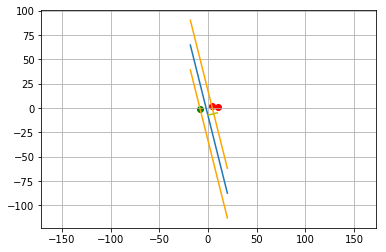

In [70]:
X = np.array([
    [10, 1],
    [4, 2],
    [-8, -1]
])
y = np.array([
    1,
    1,
    -1
])

alpha_ref, beta_ref, beta0_ref = svm_hard_lib(X, y)
print('alpha =', alpha_ref)
print('beta =', beta_ref)
print('beta0 =', beta0_ref)
plot_data_support(beta_ref, beta0_ref, X, y)

alpha = [2.64926778e-01 1.08766882e-12 2.82986912e-12 1.49301958e-11
 1.34503762e-12 7.12935312e-12 2.62526127e-12 1.44833518e-13
 4.01791819e-12 3.92182076e-02 2.63401040e-12 1.19652476e-12
 9.75367128e-13 3.85021290e-13 1.45322696e-12 3.04144986e-01
 4.49445516e-13 1.07180325e-12 1.03454379e-12 4.67622026e-13
 1.33920667e-12 6.09329737e-13 2.82967211e-12 7.31659608e-13]
beta = [0.60863972 0.48769628]
beta0 = 0.4945487191858977


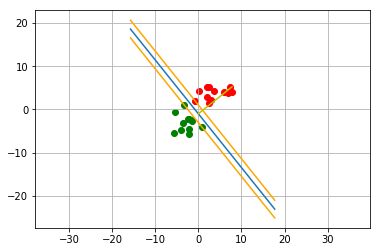

In [71]:
np.random.seed(18)

N = 25
P = 2
X21 = np.random.randn(int(N/2), P) * 2 - 3.4
X22 = np.random.randn(int(N/2), P) * (-2) + 4.2
X2 = np.concatenate((X21, X22), axis=0)
rb = np.random.randn(P)
rb0 = np.random.randn()
y2 = np.sign(X2 @ rb + rb0)

alpha_ref2, beta_ref2, beta0_ref2 = svm_hard_lib(X2, y2)
print('alpha =', alpha_ref2)
print('beta =', beta_ref2)
print('beta0 =', beta0_ref2)
plot_data_support(beta_ref2, beta0_ref2, X2, y2)

## Interior point method

Solve the following problem:

$$\min_{x} \frac{1}{2} x^TQx + c^Tx$$
$$\text{s.t. } Ax = b$$
$$\text{s.t. } x_i \geq 0 i=1,\text{...},n$$

with $x \in \mathbb{R}^n$, $Q \in \mathbb{R}^{n*n}$, $c \in \mathbb{R}^n$, $A \in \mathbb{R}^{m*n}$, $b \in \mathbb{R}^m$.  

We replace the inequalies contraints by the log-barrier:

$$\min_{x} \frac{1}{2} x^TQx + c^Tx - \mu \sum_{j=1}^n \ln x_j$$
$$\text{s.t. } Ax = b$$

with $\mu \geq 0$ the barrier parameter

The Lagrangian is:

$$\mathcal{L}(x, y, \mu) = x^TQx + c^Tx - y^T(Ax - b) - \mu \sum_{j=1}^n \ln x_j$$

Find stationnary points:

$$\frac{\partial}{\partial x} \mathcal{L}(x,y,\mu) = 0$$
$$c - A^Ty - \mu X^{-1}e + Qx = 0$$

with $e \in \mathbb{R}^n$ a vector of ones, and $X \in \mathbb{R}^{n*n} = \text{diag}(x)$  

$$\frac{\partial}{\partial y} \mathcal{L}(x,y,\mu) = 0$$
$$Ax - b = 0$$

Let's define $s \in \mathbb{R}^n$ and $S \in \mathbb{R}^{n*n} = \text{diag}(s)$ such that:
$$s = \mu X^{-1}e, \text{ i.e. } X Se = \mu e$$

The first order optimality conditions are:

$$Ax - b = \vec{0}$$
$$A^Ty + s - Qx - c = \vec{0}$$
$$X Se - \mu e = \vec{0}$$

Let $F: \mathbb{R}^{2n + m} \to \mathbb{R}^{2n + m}$ an application defined as:

$$
\begin{gather}
F(x, y, s) =
  \begin{bmatrix}
   Ax - b \\
   A^Ty + s - Qx - c \\
   XSe - \mu e
   \end{bmatrix}
\end{gather}
$$

This forms a large system of non-linear equations (two firsts blocks are linear, bust last block is not).  
The objective is to solve $F(x,y,s) = \vec{0}$

The system can be solved using the newton method:

The Jacobian of $F$ is:

$$
\begin{gather}
J(F) =
  \begin{bmatrix}
   A & 0 & 0 \\
   -Q & A^T & I\\
   S & 0 & X
   \end{bmatrix}
\end{gather}
$$

The newton step can by calculated by solving $J(F) \Delta x = -F(x)$.  
We then have a system of linear eqations:

$$
\begin{gather}
 \begin{bmatrix}
   A & 0 & 0 \\
   -Q & A^T & I\\
   S & 0 & X
   \end{bmatrix}
   \cdot
   \begin{bmatrix}
   \Delta x\\
   \Delta y\\
   \Delta s
   \end{bmatrix}
 =
\begin{bmatrix}
   b - Ax \\
   c - A^Ty - s + Qx\\
   \mu e - XSe
   \end{bmatrix}
\end{gather}
$$

### Algorithm

#### Initialization

Start with initial vectors $x, y, s$ and, an initial value for $\mu$, such that $x_i > 0$, $s_i > 0$, and $\mu > 0$.  
Can be chosen randomly


#### Iteration

Determine $\Delta x, \Delta y, \Delta s$ by solving the linear system above.  

$$x \leftarrow x + \alpha \Delta x$$
$$y \leftarrow y + \alpha \Delta x$$
$$s \leftarrow s + \alpha \Delta x$$

with $\alpha \in \mathbb{R}, \alpha > 0$ learning rate.

$\alpha$ should be chosen sutch that:
$$x_i + \alpha \Delta x_i > 0$$
$$s_i + \alpha \Delta s_i > 0$$

Decrease $\mu$, should converge to $0$


#### Termination
    
Stop when the solution of the third equation, non linear, is precise enough:
$$\mu e - XSe = 0$$
$$\mu = x^Ts$$

Af $k \to \infty$, $\mu \to 0$, so the equation is:
$$x^Ts = 0$$

So the stop condition is:
$$x^Ts < \epsilon$$
with $\epsilon > 0$ an error thresold close to $0$

iter: 223
alpha = [3.28979308e-11 1.30718955e-02 1.30718955e-02]
beta = [0.15686275 0.03921569]
beta0 = 0.29411764880187136
diff: 1.0261982259819589e-10


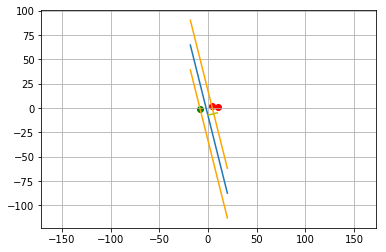

In [348]:
def point_method_qp(Q, c, A, b):
    
    MAX_ITERS = 500
    ERR_THRESH = 1e-10
    ALPHA_MAX= 0.1
    
    n = Q.shape[0]
    m = A.shape[0]
    
    #Initialize values
    x = np.random.rand(n)
    y = np.random.rand(m)
    s = np.random.rand(n)
    e = np.ones(n)
    mu = 0.9
    
    for k in range(MAX_ITERS):
        
        X = np.diag(x)
        S = np.diag(s)
        
        #build jacobian matrix of F
        ll1 = np.concatenate((A, np.zeros((m, m+n))), axis=1)
        ll2 = np.concatenate((-Q, A.T, np.eye(n)), axis=1)
        ll3 = np.concatenate((S, np.zeros((n, m)), X), axis=1)
        J = np.concatenate((ll1, ll2, ll3), axis=0)
        
        #build right-hand of system
        rl1 = b - A@x
        rl2 = c - A.T@y - s + Q@x
        rl3 = mu * e - X@S@e
        RS = np.concatenate((rl1, rl2, rl3), axis=0)
        
        #Get delta
        delta_full = np.linalg.solve(J, RS)
        dx = delta_full[:n]
        dy = delta_full[n:m+n]
        ds = delta_full[m+n:]
            
        step = np.concatenate((-x / dx, -s / ds))
        a_max = step[np.argmin(np.abs((step)))]
        a_max = a_max * 0.5
        if a_max < 0:
            a_max = ALPHA_MAX
        
        lr = min(ALPHA_MAX, a_max)
        x += lr * dx
        y += lr * dy
        s += lr * ds
        mu *= 0.5
        
        #terminal criterion
        err = x @ s
        if err < ERR_THRESH:
            break
        
        #break
        
    
    print('iter:', k)
    return x


def svm_hard(X, y):
    n, p = X.shape
    X = X.astype(np.double)
    y = y.astype(np.double)
    
    Q = (y.reshape(-1, 1)*X @ (y.reshape(-1, 1)*X).T)
    c = -np.ones(n)
    A = y.reshape(1, -1)
    b = np.zeros(1)
    alpha = point_method_qp(Q, c, A, b)
    
    beta = (y * alpha) @ X
    S = (alpha > 1e-4)
    beta0 = y[S] - (X[S] @ beta)
    beta0 = np.mean(beta0)
    
    return alpha, beta, beta0
    
alpha, beta, beta0 = svm_hard(X, y)
print('alpha =', alpha)
print('beta =', beta)
print('beta0 =', beta0)
print('diff:', metrics.tdist(alpha, alpha_ref))

plot_data_support(beta, beta0, X, y)

iter: 238
alpha = [2.64926778e-01 1.58959081e-12 6.09910978e-12 9.77431473e-12
 1.32584215e-12 7.48981470e-12 1.06179380e-12 1.91587511e-12
 3.56336768e-12 3.92182076e-02 1.30567475e-12 8.01181264e-13
 6.63942905e-13 4.36238993e-13 2.04046038e-12 3.04144986e-01
 4.40684666e-13 9.26134210e-13 1.03729550e-12 1.23617856e-12
 1.30390509e-12 1.91788806e-12 3.11299422e-12 2.56209518e-13]
beta = [0.60863972 0.48769628]
beta0 = 0.4945487197465103
diff: 2.7124445272978356e-10


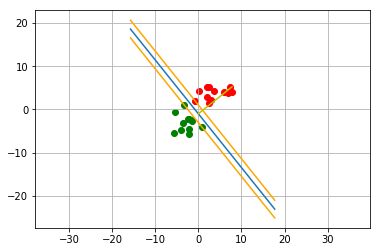

In [349]:
alpha, beta, beta0 = svm_hard(X2, y2)
print('alpha =', alpha)
print('beta =', beta)
print('beta0 =', beta0)
print('diff:', metrics.tdist(alpha, alpha_ref2))

plot_data_support(beta, beta0, X2, y2)

In [350]:
S = (alpha > 1e-4)
S_idxs = np.arange(len(X2))[S]
S_vecs = X2[S_idxs]
S_nc = np.array([
    np.sum(y2[S_idxs] == -1),
    np.sum(y2[S_idxs] == +1),
])

y_pred = np.sign(X2 @ beta + beta0)
acc = np.average(y2 == y_pred)

print('beta:', beta)
print('beta_0:', beta0)
print('Indices of support vectors:', S_idxs)
print('Support vectors:', S_vecs)
print('Number of support vectors for each class:', S_nc)
print('Accuracy:', acc)

beta: [0.60863972 0.48769628]
beta_0: 0.4945487197465103
Indices of support vectors: [ 0  9 15]
Support vectors: [[-3.24114311  0.98040471]
 [ 0.73409373 -3.98064823]
 [-0.72740321  1.94419727]]
Number of support vectors for each class: [2 1]
Accuracy: 1.0


In [351]:
#Comparing with sklearn

from sklearn.svm import SVC
clf = SVC(C = 1e10, kernel = 'linear')
clf.fit(X2, y2)

y_pred = clf.predict(X2)
acc = np.average(y2 == y_pred)

print('beta:', clf.coef_)
print('beta_0:', clf.intercept_)
print('Indices of support vectors:', clf.support_)
print('Support vectors:', clf.support_vectors_)
print('Number of support vectors for each class:', clf.n_support_)
print('Accuracy:', acc)

beta: [[0.60842821 0.48764409]]
beta_0: [0.49430228]
Indices of support vectors: [ 0  9 15]
Support vectors: [[-3.24114311  0.98040471]
 [ 0.73409373 -3.98064823]
 [-0.72740321  1.94419727]]
Number of support vectors for each class: [2 1]
Accuracy: 1.0
